# News Analysis with LLM (Gemini)

In [85]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [86]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [87]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [88]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format:

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.]

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [89]:
import pandas as pd
import numpy as np

In [175]:
df = pd.read_csv("../../DataCollection/Data/News/AMZN_2025-05-26_13-36-10.csv")
display(df.head())

,ticker,publish_date,publish_time,title,body_text,url
0,AMZN,2025-05-23,14:36,Amazon.com is sued over alleged sale of contam...,By Jonathan Stempel\n\n(Reuters) - Amazon.com ...,https://www.investing.com/news/stock-market-ne...
1,AMZN,2025-05-23,14:14,Oracle to buy $40 billion of Nvidia chips for ...,(Reuters) -Oracle will spend around $40 billio...,https://www.investing.com/news/stock-market-ne...
2,AMZN,2025-05-23,09:19,Amazon not seeing notable impact from tariffs ...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/pro/amazon-not-...
3,AMZN,2025-05-23,09:04,Amazon Com Inc receives Investment Bank Analys...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/pro/da-davidson...
4,AMZN,2025-05-23,05:53,Wall St falls as Trump tariff threats spark ma...,By Chibuike Oguh\n\nNEW YORK (Reuters) -U.S. s...,https://www.investing.com/news/stock-market-ne...


In [176]:
df.isnull().sum()

ticker          0
publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [177]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [178]:
print(df.head())

  ticker publish_date publish_time  \
0   AMZN   2025-05-23        14:36   
1   AMZN   2025-05-23        14:14   
2   AMZN   2025-05-23        09:19   
3   AMZN   2025-05-23        09:04   
4   AMZN   2025-05-23        05:53   

                                               title  \
0  Amazon.com is sued over alleged sale of contam...   
1  Oracle to buy $40 billion of Nvidia chips for ...   
2  Amazon not seeing notable impact from tariffs ...   
3  Amazon Com Inc receives Investment Bank Analys...   
4  Wall St falls as Trump tariff threats spark ma...   

                                           body_text  \
0  By Jonathan Stempel\n\n(Reuters) - Amazon.com ...   
1  (Reuters) -Oracle will spend around $40 billio...   
2  Risk Disclosure: Trading in financial instrume...   
3  Risk Disclosure: Trading in financial instrume...   
4  By Chibuike Oguh\n\nNEW YORK (Reuters) -U.S. s...   

                                                 url  
0  https://www.investing.com/news/stock-ma

In [179]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "Unknown Stock")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting:   0%|          | 0/20 [00:00<?, ?it/s]

Prompting: 100%|██████████| 20/20 [01:53<00:00,  5.67s/it]


In [180]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [181]:
print(df["title"][2],'\n\n',predicted[2])

Amazon not seeing notable impact from tariffs yet, Q2 revenue tracking higher By Investing.com 

 **Sentiment:**
Positive

**Summary:**
Amazon reports that it is not currently experiencing a significant negative impact from tariffs. Furthermore, the company's second-quarter revenue is reportedly tracking higher.

**Reasoning for Sentiment:**
The news indicates that a potential negative factor (tariffs) is not currently affecting Amazon's business notably, while a key performance indicator (revenue) is showing positive growth.

**Importance to Stock AMZN:**
5

**Reasoning for Importance:**
This information is highly important as it provides insight into Amazon's current financial performance (revenue tracking higher) and its resilience to significant external economic factors like tariffs, which directly impacts investor confidence and valuation.


In [182]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip())
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip())
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip())

In [183]:
df[df["importance"]== "4"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
4,2025-05-23,Wall St falls as Trump tariff threats spark ma...,Negative,4,US stocks experienced a significant decline on...
10,2025-05-22,Ackman’s hedge fund Pershing Square bets on Am...,Positive,4,"Billionaire investor Bill Ackman's hedge fund,..."
11,2025-05-22,U.S. stocks mixed at close of trade; Dow Jones...,Positive,4,The article reports on the mixed close of the ...
15,2025-05-22,Startup Anthropic says its new AI model can co...,Positive,4,"AI startup Anthropic, backed by Amazon, has la..."


In [184]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,ticker,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary
7,AMZN,2025-05-22,20:00,This CEO ’is making all the right moves to unl...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/pro/this-ceo-is...,"Based on the provided text, which consists sol...",,,


<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

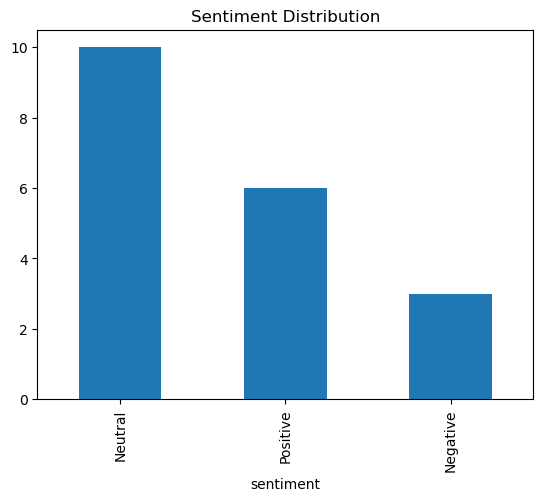

In [185]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

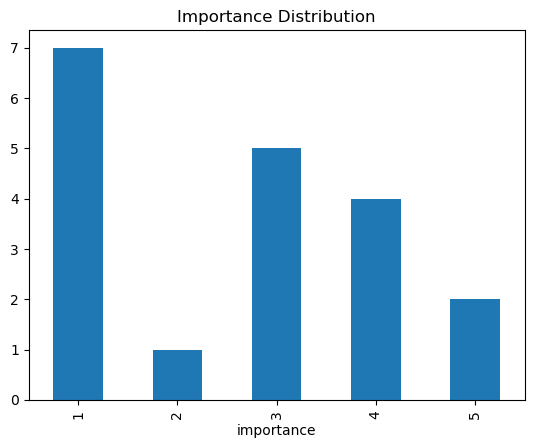

In [186]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [187]:
TICKER=df["ticker"][0]

In [188]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [189]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [190]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for AMZN: 0.34


In [191]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini_{TICKER}_{date_time}.csv", index=False)